## Assignment 4 Formative

Students: Yihan Bao (1174241), Lang Chen (1181506)

### Title：
Spatial Analysis of Train Service Demand in Greater Melbourne

### Research Question:
How do population characteristics and location of non-residential properties impact the demand for train services?

### Aim:
Our research intends to build regression models to statistically explain daily train demand using population density, other population features, rainfall characteristics, demand at other stations and buildings in the proximity of the stations. The best model will also be used to estimate demand for a train station hypothetically built at any location in Greater Melbourne will attract, to advice government decisions for expanding railways which drives sustainability through diverting high demand for commute from high green-house gas emitting car travel to trains.

### Code for Map:

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily
from shapely.geometry import LineString
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D


In [2]:
# station demand dataset
post_covid_mean_daily_train_demand = gpd.read_file('../data/curated/post_covid_mean_daily_train_demand.gpkg')

In [3]:
# population density dataset
population = gpd.read_file('../data/POPULATION_2023_SA2_GDA2020/32180_ERP_2023_SA2_GDA2020.gpkg')
population['density_2021'] = population['ERP_2021'] / population['Area_km2']
population['log(density_2021)'] = np.log(population['density_2021'])

In [4]:
def add_map_components(ax, bound, interval, arrow_pos=None):

    '''
        This function adds cartographic components on the map,
        including: Grid, Axes, Axes Label, North Arrow, Legends, Scale Bar
        It will be applied to every map later in the project
    '''
    # Add orientation arrow
    if arrow_pos == 'left':
        x, y, arrow_length = 0.08, 0.95, 0.1
    if arrow_pos == 'right':
        x, y, arrow_length = 0.92, 0.95, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=3, headwidth=10),
                ha='center', va='center', fontsize=13, xycoords=ax.transAxes)
    
    # Add axis label
    ax.annotate('Northing', xy=(-0.2,0.45),
                fontsize=11, xycoords=ax.transAxes, rotation=90)
    ax.annotate('Easting', xy=(0.45,-0.12),
                fontsize=11, xycoords=ax.transAxes)
    
    # Remove unnecessary axis
    ax.set_axis_off()

    # Make some offest to avoid map touching boundary
    # Round to create whole number axis
    xmin, ymin, xmax, ymax = bound
    xmin = np.floor(xmin / interval - 0.4) * interval
    ymin = np.floor(ymin / interval - 0.4) * interval
    xmax = np.ceil(xmax / interval + 0.4) * interval
    ymax = np.ceil(ymax / interval + 0.4) * interval
    # Generate lines for graticule
    horizontal = np.arange(np.floor(ymin), np.ceil(ymax), interval)
    vertical = np.arange(np.floor(xmin), np.ceil(xmax), interval)

    # Plot horizontal lines
    for each in horizontal:
        line = LineString([(xmin, each), (xmax, each)])
        ax.annotate(f'{int(each)}', xy=(xmin+20000, each), xytext=(-60, -5),
                    textcoords="offset points")
        ax.plot(*line.xy, color='grey', linewidth=0.6, alpha=0.7)
    
    # Plot vertical lines
    for each in vertical:
        line = LineString([(each, ymin), (each, ymax)])
        ax.annotate(f'{int(each)}', xy=(each, ymin+10000), xytext=(-15, -35),
                    textcoords="offset points", rotation=45)
        ax.plot(*line.xy, color='grey', linewidth=0.6, alpha=0.7)

    # Add Scale Bar
    scalebar = ScaleBar(100, 'cm', 
                        length_fraction=0.15, 
                        location='lower right', 
                        frameon=True, 
                        color='black', 
                        scale_loc='bottom', label_loc='bottom', 
                        font_properties={'size': 12})
    
    ax.add_artist(scalebar)

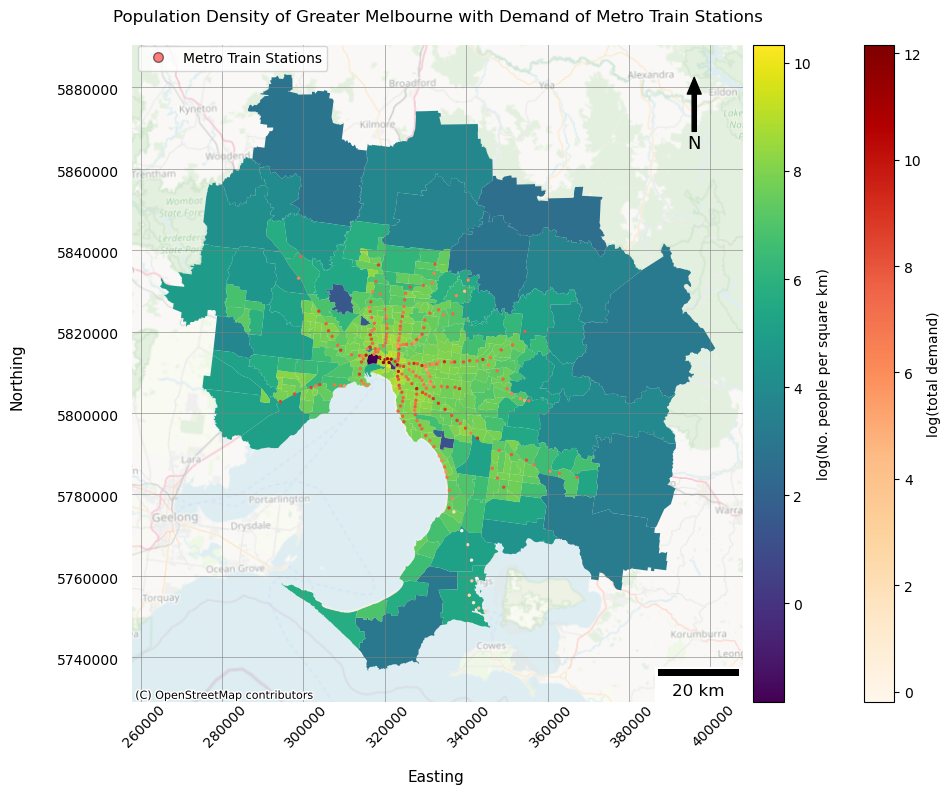

In [5]:
# Plot population density and tain demand
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.1)
cax2 = divider.append_axes("right", size="5%", pad=0.8)

population.plot(column='log(density_2021)',
                ax=ax,
                legend=True,
                cax = cax1,
                legend_kwds={'label': "log(No. people per square km)",'orientation': "vertical"})


post_covid_mean_daily_train_demand.plot(column='log_Total_Demand', 
                                        ax=ax, 
                                        legend=True,
                                        cax=cax2,
                                        legend_kwds={'label': "log(total demand)",'orientation': "vertical"},
                                        markersize=2, alpha=1, cmap='OrRd')


contextily.add_basemap(ax=ax, 
                       crs = population.crs.to_string(), 
                       source = contextily.providers.OpenStreetMap.Mapnik, 
                       alpha=0.4)

legend = [Line2D([0], [0], marker='o', 
                        color='r',
                        linestyle='None',
                        markeredgecolor='black', 
                        markersize=7, 
                        alpha = 0.5, 
                        label='Metro Train Stations')]  

ax.legend(handles=legend, loc=(0.01,0.96))

add_map_components(ax, bound=population.total_bounds, interval=20000, arrow_pos='right')
ax.set_title("Population Density of Greater Melbourne with Demand of Metro Train Stations")
plt.tight_layout()
plt.show()

In [6]:
# Read non-residential facilities
facilities = gpd.read_file('../data/non-residential_facilities.gpkg')
joined_df = gpd.sjoin(population, facilities, how="left", predicate='intersects')
# Count number of facilities per SA2
point_counts = joined_df.groupby('SA2_name_2021').size().reset_index(name='point_count')
point_counts['point_density'] = point_counts['point_count'] / point_counts['Area_km2']
point_counts['log(point_density)'] = np.log(point_counts['point_density'])

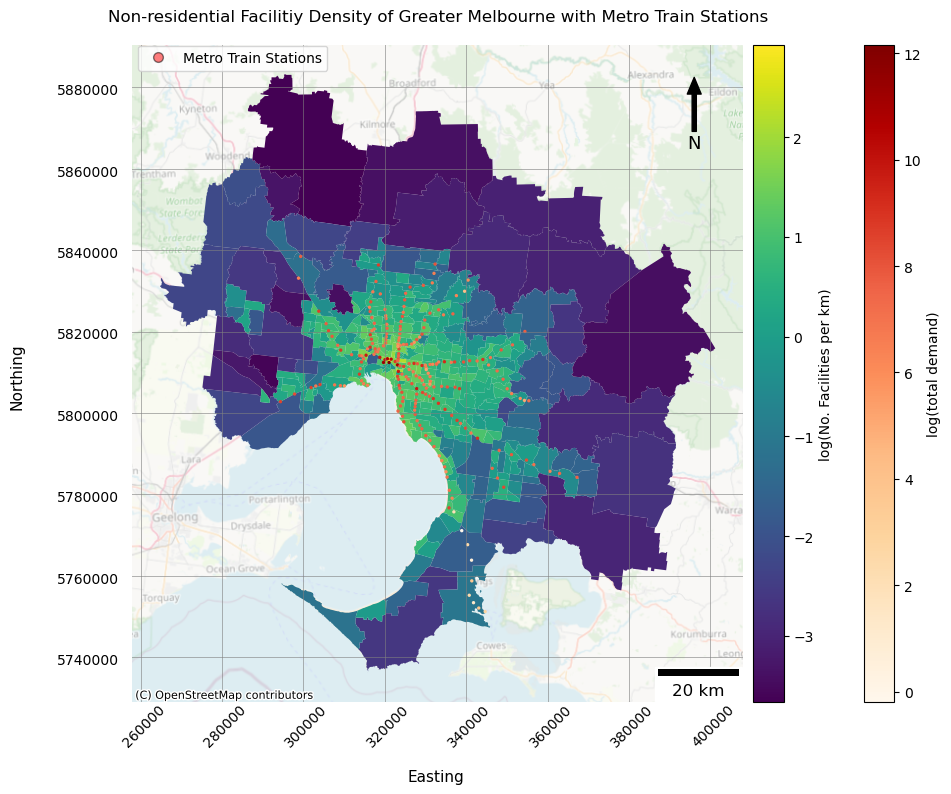

In [8]:
# Plot facilities and train demand
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.1)
cax2 = divider.append_axes("right", size="5%", pad=0.8)
point_counts.plot(column='log(point_density)', ax=ax, 
                   legend=True,
                   cax=cax1,
              legend_kwds={'label': "log(No. Facilities per km)",
                           'orientation': "vertical"})

post_covid_mean_daily_train_demand.plot(column='log_Total_Demand', 
                                        ax=ax, 
                                        legend=True,
                                        cax=cax2,
                                        legend_kwds={'label': "log(total demand)",'orientation': "vertical"},
                                        markersize=2, alpha=1, cmap='OrRd')

legend = [Line2D([0], [0], marker='o', 
                        color='r',
                        linestyle='None',
                        markeredgecolor='black', 
                        markersize=7, 
                        alpha = 0.5, 
                        label='Metro Train Stations')]  

ax.legend(handles=legend, loc=(0.01,0.96))
contextily.add_basemap(ax=ax, 
                       crs = population.crs.to_string(), 
                       source = contextily.providers.OpenStreetMap.Mapnik, 
                       alpha=0.4)
add_map_components(ax, bound=population.total_bounds, interval=20000, arrow_pos='right')
ax.set_title("Non-residential Facilitiy Density of Greater Melbourne with Metro Train Stations")
plt.tight_layout()
plt.show()

### Interpretation of Maps:

The first map:\
The polygons show population density of each SA2 region in Greater Melbourne, and points represent daily train demand in each station. We observe a positive correlation between mean daily train demand and population, suggesting that local population statistics around each station may positively influence train demand. We have decided to estimate population statistic features for a train station using a circular area around them, with radius equal to average nearest neighbour of stations (1420m).

The second map:\
The polygons show non-residential facility density of each SA2 region in Greater Melbourne, and points represent daily train demand in each station. A similar correlation is observed, we will include a boolean feature for each building type, indicating whether such buildings are found within half the average nearest neighbour distance (710m) to stations, to best avoid the same building contributing to multiple stations. 

The positive correlations support our hypothesis, for example, a region with high population and non-residential facility density should have higher train demand. However, from the maps, we observe some of such area is not covered by train networks, indicating possible recommendations for future train stations. This result encourages our further spatial analysis to provide more reliable implementations.

We plan to re-formularise Geographically Weighted Regression as Kernalised Regression, where a kernel preprocesses by weighting the geographically distributed variables based on distance (e.g. demand at other stations). Then, we can apply machine learning algorithms (such as regression, neural networks, etc.) to model this problem. 